In [18]:
import os

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import wn

from OMWMetricsExtractor import OMWMetricsExtractor

from utils import get_path_from_root, get_resource_word_match
from analyzer import OMWBasicnessAnalyzer

In [19]:
# Download the necessary resources if they are not already present
# wn.download('omw:1.4')
# wn.download('cili:1.0')

In [20]:
enable_plots = False
use_ili_list = False
langs = ("en", "it", "nb", "es")
# Choose resource set type
resource_set_type = "annotation_culture_gold_it"
fixed_thresholds = [0.25, 0.5, 0.75]

In [21]:
if resource_set_type == "annotation_culture":
    out_prefix = "annotation_culture_copy"
    input_path = get_path_from_root("resources/annotation/culture_annotated_silver_simple_majority_voting.xlsx")
    json_path = get_path_from_root(f"results/omw/{out_prefix}_omw_extracted.json")
    csv_path = get_path_from_root(f"results/omw/{out_prefix}_omw_extracted.csv")
    analysis_name = f"{out_prefix}_omw_scored"
elif resource_set_type == "annotation_culture_gold_it":
    out_prefix = "annotation_culture_gold_it_copy"
    input_path = get_path_from_root("resources/annotation/culture_annotated_gold_it_majority_voting.xlsx")
    json_path = get_path_from_root(f"results/omw/{out_prefix}_omw_extracted.json")
    csv_path = get_path_from_root(f"results/omw/{out_prefix}_omw_extracted.csv")
    analysis_name = f"{out_prefix}_omw_scored"
else:
    raise ValueError(f"Invalid resource_set_type: {resource_set_type}")

In [22]:
if resource_set_type in ["annotation_culture", "annotation_culture_gold_it"]:
    # Load annotation culture ilis
    df = pd.read_excel(input_path)
    input = df["ili"].tolist()
    use_ili_list = True

In [23]:
extractor = OMWMetricsExtractor()

In [24]:
# Extract synsets data
data_dict = extractor.extract(input, verbose=False, json_path=json_path, csv_path=csv_path, 
                              filter_zero_freq=True, languages=langs, max_lemmas=3, use_ili_list=use_ili_list)

/home/gianluca/Documents/borsa/code/Basicness/src/classification/OMWMetricsExtractor.py:314: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Gloss'].replace({'nd'}, None, inplace=True)


In [25]:
# Load synsets data from csv
all_synsets_df = pd.read_csv(csv_path)
all_synsets_df

,Language,Synset,ili,Gloss,Lemma,n_hyponyms,n_synonyms,n_syn_senses,word_length,word_frequency,pronounce_complexity,word_in_children_res,word_in_second_lang_learn_res,n_senses
0,en,Synset('omw-en-15168185-n'),i116927,12 o'clock at night; the middle of the night,midnight,0,1,1,8,0.000020,0.638,0,0,1
1,en,Synset('omw-en-07929519-n'),i78981,a beverage consisting of an infusion of ground...,java,13,2,7,4,0.000010,0.820,0,0,3
2,en,Synset('omw-en-07929519-n'),i78981,a beverage consisting of an infusion of ground...,coffee,13,2,7,6,0.000072,0.344,0,1,4
3,en,Synset('omw-en-07933274-n'),i79004,a beverage made by steeping tea leaves in water,tea,5,1,5,3,0.000054,0.193,0,1,5
4,en,Synset('omw-en-09328904-n'),i85647,a body of (usually fresh) water surrounded by ...,lake,51,1,3,4,0.000068,0.193,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
462,es,Synset('omw-es-05946687-n'),i68078,NaN,credo,7,3,10,5,0.000002,0.567,0,1,2
463,es,Synset('omw-es-05946687-n'),i68078,NaN,fe,7,3,10,2,0.000085,0.184,0,0,6
464,es,Synset('omw-es-02984061-n'),i51645,NaN,catedral,0,1,2,8,0.000018,0.753,0,1,2
465,es,Synset('omw-es-09328904-n'),i85647,NaN,lago,6,1,1,4,0.000030,0.185,0,1,1


## Basicness Analysis: Calculation and Evaluation

In [26]:
# opt_path = get_path_from_root("resources/annotation/culture_annotated_silver_simple_majority_voting.xlsx")
opt_path = get_path_from_root("resources/annotation/culture_annotated_gold_it_majority_voting.xlsx")
analyzer = OMWBasicnessAnalyzer(all_synsets_df, opt_set_path=opt_path)

In [27]:
# Load correlation-based weights
correlation_path = get_path_from_root("../../results/correlation/unfiltered/spearman_correlations.csv")
language_specific_weights = OMWBasicnessAnalyzer.load_correlation_weights(correlation_path)

# Set the language weights for the analysis
analyzer.set_language_specific_weights(language_specific_weights)

# Display the weights for each language
for lang, weights in language_specific_weights.items():
    print(f"\n--- {lang} specific weights ---")
    for key, value in weights.items():
        print(f"\t{key}: {value}")


--- en specific weights ---
	word_frequency_weight: 0.4975194119970945
	word_length_weight: -0.1648349442802383
	pronounce_complexity_weight: -0.13481534366354
	n_hyponyms_weight: 0.1610916023329112
	n_synonyms_weight: -0.2137141879710336
	n_senses_weight: -0.0732411059719357
	word_in_children_res_weight: 0.262514805918938
	word_in_second_lang_learn_res_weight: 0.3522947679483945
	n_syn_senses_weight: -0.2084357095723361

--- it specific weights ---
	word_frequency_weight: 0.4303661205459141
	word_length_weight: -0.4199257170488138
	pronounce_complexity_weight: -0.1993844641840826
	n_hyponyms_weight: 0.350961698701289
	n_synonyms_weight: -0.1981350313136889
	n_senses_weight: 0.0872046033524559
	word_in_children_res_weight: 0.3212639278934397
	word_in_second_lang_learn_res_weight: 0.3983495968117755
	n_syn_senses_weight: -0.091663880259736

--- es specific weights ---
	word_frequency_weight: 0.3948452796526028
	word_length_weight: -0.3960605202906034
	pronounce_complexity_weight: -0.29

In [28]:
# Analyze synsets data using correlation-based weights
all_synsets_lang_syn_df = analyzer.analyze_lang_syn_group(word=analysis_name + "_correlation_weights", thresholds=fixed_thresholds)
# Reset indexes
all_synsets_lang_syn_df = all_synsets_lang_syn_df.reset_index(drop=True)
all_synsets_lang_syn_df

,Language,basicness_score_experimental,basicness_rank,basicness_score,word_in_children_res,word_in_second_lang_learn_res,en_lemmas,n_hyponyms,n_synonyms,n_syn_senses,...,avg_n_senses,normalized_length,normalized_pronounce_complexity,normalized_n_senses,normalized_frequency,normalized_n_hyponyms,normalized_n_synonyms,example_en_lemma,example_en_gloss,ili
0,en,0.752695,4,0.178189,0,0,"rose, rosebush",11,2,4,...,2.000000,0.300000,0.4865,0.142857,0.065887,0.055000,0.090909,rose,any of many shrubs of the genus Rosa that bear...,i103203
1,nb,0.728238,3,1.000000,1,1,"rose, rosebush",0,1,1,...,1.000000,0.125000,0.4660,0.000000,0.031567,0.000000,0.000000,rose,any of many shrubs of the genus Rosa that bear...,i103203
2,es,0.662313,3,0.202044,0,0,"rose, rosebush",0,1,5,...,5.000000,0.166667,0.1860,0.307692,0.063394,0.000000,0.000000,rose,any of many shrubs of the genus Rosa that bear...,i103203
3,it,0.656120,3,0.000000,0,0,"rose, rosebush",5,2,10,...,5.000000,0.214286,0.1925,0.225806,0.033582,0.068493,0.090909,rose,any of many shrubs of the genus Rosa that bear...,i103203
4,nb,0.972162,4,1.000000,0,0,wood,0,1,2,...,2.000000,0.000000,0.4420,0.111111,1.000000,0.000000,0.000000,wood,the hard fibrous lignified substance under the...,i116549
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275,it,0.656449,3,0.000000,0,0,"snowfall, snow",2,2,5,...,2.500000,0.285714,0.1995,0.064516,0.014671,0.027397,0.090909,snowfall,precipitation falling from clouds in the form ...,i98073
276,it,0.984573,4,0.509686,1,1,"conditions, weather, weather condition",13,1,17,...,17.000000,0.214286,0.5240,1.000000,1.000000,0.178082,0.000000,conditions,the atmospheric conditions that comprise the s...,i98170
277,es,0.966547,4,0.000000,1,0,"conditions, weather, weather condition",6,4,9,...,2.666667,0.888889,0.8110,0.128205,0.453217,0.162162,0.750000,conditions,the atmospheric conditions that comprise the s...,i98170
278,en,0.894981,4,0.236577,0,1,"conditions, weather, weather condition",11,4,6,...,1.666667,0.833333,0.6320,0.095238,0.145011,0.055000,0.272727,conditions,the atmospheric conditions that comprise the s...,i98170


### Plot basicness score distribution

In [29]:
# Get basicness scores
scores = all_synsets_lang_syn_df["basicness_score_experimental"].values

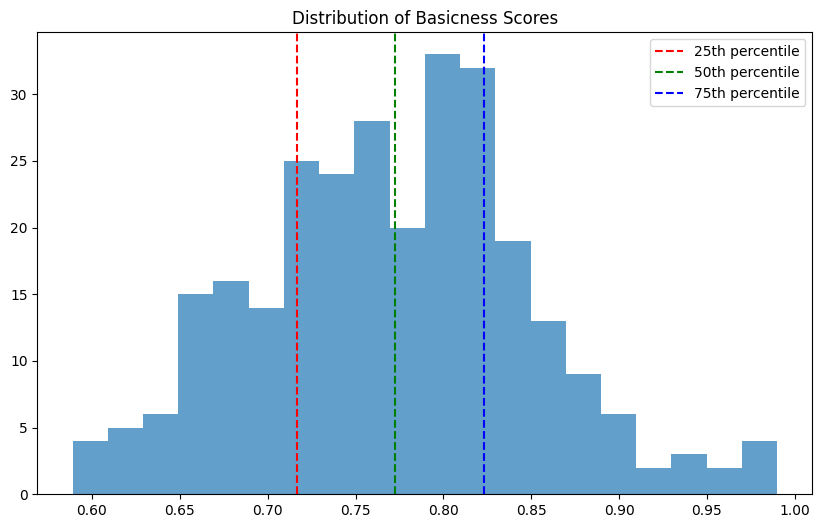

In [30]:
# Plot histogram to visualize distribution
plt.figure(figsize=(10, 6))
plt.hist(scores, bins=20, alpha=0.7)
plt.axvline(np.percentile(scores, 25), color='r', linestyle='--', label='25th percentile')
plt.axvline(np.percentile(scores, 50), color='g', linestyle='--', label='50th percentile')
plt.axvline(np.percentile(scores, 75), color='b', linestyle='--', label='75th percentile')
plt.legend()
plt.title('Distribution of Basicness Scores')
plt.show()

## Evaluation

In [31]:
from src.analysis.agreements import calculate_feature_human_agreement

human_it_annotation_path = "../../data/human_annotations/culture_annotation_datasets_annotated_human_it.csv"
human_en_annotation_path = "../../data/human_annotations/culture_annotation_datasets_annotated_human_en.csv"
human_es_annotation_path = "../../data/human_annotations/culture_annotation_datasets_annotated_human_es.csv"
human_nb_annotation_path = "../../data/human_annotations/culture_annotation_datasets_annotated_human_nb.csv"

HUMAN_ANNOTATION_PATHS = {"en": human_en_annotation_path, 
                          "it": human_it_annotation_path,
                          "es": human_es_annotation_path,
                          "nb": human_nb_annotation_path}

# Load human annotations
HUMAN_ANNOTATION_DFS = { lang: pd.read_csv(path) for lang, path in HUMAN_ANNOTATION_PATHS.items() }

In [34]:
def evaluate_all_annotations_agreements(feature_df: pd.DataFrame, human_annotation_dfs: dict, feature_weights: dict):
    print("Used weights:")
    for key, weight_dict in feature_weights.items():
        print(f"\t{key}")
        for label, weight in weight_dict.items():
            print(f"\t\t{label}: {weight}")
    print("\n")
    print("--------------------- Agreement ---------------------")
    for lang, human_annotation_df in human_annotation_dfs.items():
        agreements = calculate_feature_human_agreement(feature_df, human_annotation_df, f"feature_human_agreement_{lang}" , lang)
        print(f"--------------------- {lang} ---------------------")
        print(agreements["overall"]["percent_agreement"])
        print("\n")

In [35]:
language_specific_weights = analyzer.get_language_specific_weights()

evaluate_all_annotations_agreements(all_synsets_lang_syn_df, HUMAN_ANNOTATION_DFS, language_specific_weights)

Weights Used:
Used weights:
	en
		word_frequency_weight: 0.4975194119970945
		word_length_weight: -0.1648349442802383
		pronounce_complexity_weight: -0.13481534366354
		n_hyponyms_weight: 0.1610916023329112
		n_synonyms_weight: -0.2137141879710336
		n_senses_weight: -0.0732411059719357
		word_in_children_res_weight: 0.262514805918938
		word_in_second_lang_learn_res_weight: 0.3522947679483945
		n_syn_senses_weight: -0.2084357095723361
	it
		word_frequency_weight: 0.4303661205459141
		word_length_weight: -0.4199257170488138
		pronounce_complexity_weight: -0.1993844641840826
		n_hyponyms_weight: 0.350961698701289
		n_synonyms_weight: -0.1981350313136889
		n_senses_weight: 0.0872046033524559
		word_in_children_res_weight: 0.3212639278934397
		word_in_second_lang_learn_res_weight: 0.3983495968117755
		n_syn_senses_weight: -0.091663880259736
	es
		word_frequency_weight: 0.3948452796526028
		word_length_weight: -0.3960605202906034
		pronounce_complexity_weight: -0.2997551158457093
		n_hyponym

### Try Other Weights/Thresholds

In [15]:
# Use percentiles as thresholds
thresholds = [
    np.percentile(scores, 25),
    np.percentile(scores, 50),
    np.percentile(scores, 75)
]

In [ ]:
# Literature-based weights
literature_weights = {
    'word_frequency_weight': 0.3,
    'word_length_weight': 2.0,
    'pronounce_complexity_weight': 0.3,
    'n_hyponyms_weight': 0.0,
    'n_synonyms_weight': 0.0,
    'n_senses_weight': 0.0,
    'word_in_children_res_weight': 0.5,
    'word_in_second_lang_learn_res_weight': 0.6,
    'n_syn_senses_weight': 0.0
}

analyzer.set_weights(literature_weights)
analyzer.set_language_specific_weights(None)  # Disable language-specific weights
all_synsets_literature_df = analyzer.analyze_lang_syn_group(word=analysis_name + "_literature_weights", thresholds=fixed_thresholds)
# Reset indexes
all_synsets_literature_df = all_synsets_literature_df.reset_index(drop=True)

In [ ]:
# Uniform weights
uniform_weights = {
    'word_frequency_weight': 1.0,
    'word_length_weight': 1.0,
    'pronounce_complexity_weight': 1.0,
    'n_hyponyms_weight': 1.0,
    'n_synonyms_weight': 1.0,
    'n_senses_weight': 1.0,
    'word_in_children_res_weight': 1.0,
    'word_in_second_lang_learn_res_weight': 1.0,
    'n_syn_senses_weight': 1.0
}

analyzer.set_weights(uniform_weights)
analyzer.set_language_specific_weights(None)  # Disable language-specific weights
all_synsets_uniform_df = analyzer.analyze_lang_syn_group(word=analysis_name + "_uniform_weights", thresholds=fixed_thresholds)
# Reset indexes
all_synsets_uniform_df = all_synsets_uniform_df.reset_index(drop=True)

In [ ]:
# Re-enable language-specific weights for further analysis
analyzer.set_language_specific_weights(language_specific_weights)

### Threshold Optimization

In [ ]:
def grid_search_thresholds(analyzer, step=0.05):
    best_accordance = 0
    best_thresholds = None
    
    # Grid search over possible threshold combinations
    for t1 in np.arange(0.1, 0.4, step):
        for t2 in np.arange(t1 + 0.1, 0.7, step):
            for t3 in np.arange(t2 + 0.1, 0.9, step):
                thresholds = [t1, t2, t3]
                accordance = analyzer.evaluate_accordance(thresholds=thresholds)
                
                if accordance > best_accordance:
                    best_accordance = accordance
                    best_thresholds = thresholds
    
    return best_thresholds, best_accordance

# best_thresholds, score = grid_search_thresholds(analyzer)
# print(f"Best thresholds: {best_thresholds}, Accordance: {score:.4f}")

### Binary Evaluation

In [ ]:
threshold = 0.4
os.makedirs(get_path_from_root("results/omw"), exist_ok=True) # create the folder results/omw if it does not exist
eval_binary = analyzer.evaluate_basicness_score_binary(threshold=threshold)
print(f"--- Binary evaluation ---")
print(f"threshold: {threshold}")
print(f"weights:")
for key, value in language_specific_weights.items():
    print(f"\t{key}: {value}")
print(eval_binary)

### Other evaluations

In [ ]:
eval_ord_reg_loss_train = analyzer.evaluate_ordinal_regression_loss(opt_split="train")
eval_ord_reg_loss_test = analyzer.evaluate_ordinal_regression_loss(opt_split="test")
eval_ord_reg_loss_full = analyzer.evaluate_ordinal_regression_loss()
print(f"Ordinal regression loss train: {eval_ord_reg_loss_train}")
print(f"Ordinal regression loss test: {eval_ord_reg_loss_test}")
print(f"Ordinal regression loss full: {eval_ord_reg_loss_full}")

In [ ]:
eval_cum_ord_loss_train = analyzer.evaluate_cumulative_ordinal_loss(opt_split="train")
eval_cum_ord_loss_test = analyzer.evaluate_cumulative_ordinal_loss(opt_split="test")
eval_cum_ord_loss_full = analyzer.evaluate_cumulative_ordinal_loss()
print(f"Ordinal cumulative loss train: {eval_cum_ord_loss_train}")
print(f"Ordinal cumulative loss test: {eval_cum_ord_loss_test}")
print(f"Ordinal cumulative loss full: {eval_cum_ord_loss_full}")

In [ ]:
eval_rank_train = analyzer.evaluate_accordance(opt_split="train")
eval_rank_test = analyzer.evaluate_accordance(opt_split="test")
eval_rank_full = analyzer.evaluate_accordance(allow_margin_error=True)
print(f"Rank train eval: {eval_rank_train}")
print(f"Rank test eval: {eval_rank_test}")
print(f"Rank full eval: {eval_rank_full}")